# Octane modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from rdkit import Chem

'''custom modules'''
from filter_data import Select_descriptors
from process_data import Scalar
from simmilarity import mean_tanimato,Leverage,Partition
from train import Model

In [2]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [3]:
df.head(5)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP,boiling_point_K
0,CCCCO,1-Butanol,98.00,263,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,92.76,...,14,12,2.750000,1.500000,0.000000,98.00,abs dev < 0.01,13,0.9,390.81
1,CCO,Ethanol,109.00,702,"Sandia, UML",[6],ETHANOL,109.0,Training,107.77,...,6,4,2.250000,1.000000,0.000000,109.00,abs dev < 0.01,2,-0.1,351.44
2,CO,Methanol,109.00,887,"Sandia, UML",[11],METHANOL,122.0,Training,105.38,...,2,1,2.000000,1.000000,0.059633,109.00,WIKIPEDIA 108.7,2,-0.5,337.85
3,CCCO,n-Propanol,104.00,1031,"Sandia, UML",[6],N-PROPANOL,104.0,Training,100.25,...,10,8,2.500000,1.250000,0.000000,104.00,abs dev < 0.01,7,0.3,370.35
4,CC1=CC=CC=C1,Toluene,118.17,1140,"Sandia, UML","[1], [3]",NaN,NaN,NaN,NaN,...,30,31,2.361111,1.666667,NaN,118.17,no alternative,42,2.7,384.62


### 1. Data preprocessing

In [4]:
### 1.1 Remove columns with missing values
misssing_val_cols = df.columns[df.isnull().any()]
print('Columns with missing values are = {}'.format(list(misssing_val_cols)))

Columns with missing values are = ['Compound Name', 'TARGET', 'Source', 'Literature Source', 'RON_Molecules_x', 'Experiment', 'Data Set', 'Predicted', 'Absolute  Error', '#Name', 'RON', 'dev', 'boiling_point_K']


In [5]:
### 1.2 Remove columns with irrelevant to modelling values
df_ = df.drop(misssing_val_cols,axis=1)

irrelevant_to_pred_columns = ['PubChem','ron_choice']

df_ = df_.drop(irrelevant_to_pred_columns,axis=1)

In [6]:
print('final dataset sie = {}'.format(df_.shape))

final dataset sie = (492, 879)


### 2. Split dataset (standartization must be applied on train set only )

In [7]:
seed = 42 # Fix random seed to make split reproducible (experiment must be reproducible)

X_train, X_test, y_train, y_test = train_test_split(df_.drop('y',axis=1), df_['y'], test_size=0.2, random_state=seed)

In [8]:
print('Train dataset size = {}'.format(X_train.shape))
print('Test dataset size = {}'.format(X_test.shape))

Train dataset size = (393, 878)
Test dataset size = (99, 878)


In [9]:
# Normilise features, so varince threshold can be applied
sc         = Scalar('minmax')

# Wrapper feature selector
wrapper    = sfs(SVR(gamma='auto'),
              n_features_to_select=50,
              scoring='neg_mean_squared_error',
              cv=5)

# Applies varience threshold, removes high correlated features, removes higly skewed vars and applies wrapper in the end.

Filter_    = Select_descriptors(0.01,0.95,None,wrapper)

sc.fit(X_train)

In [10]:
X_train  = Filter_.transform(sc.transform(X_train),y_train)

In [11]:
X_train.head(5)

,SMILES,nAromAtom,nAtom,AATS1dv,AATS1s,AATS2s,ATSC1dv,ATSC2Z,AATSC1dv,AATSC2v,...,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA8,nARing,nRot,RotRatio,JGT10,Radius,XLogP
0,Cc1c(C)cccc1C,1.0,0.517241,0.576389,0.282591,0.282991,0.730492,0.700621,0.740440,0.878198,...,0.000000,0.000000,0.324926,0.762583,0.000000,0.000000,0.000000,0.578490,0.50,0.640625
1,CC1CCCC(C1)C,0.0,0.620690,0.210069,0.047170,0.042662,0.230335,0.359969,0.366775,0.521145,...,0.000000,0.460837,0.500000,0.270972,0.333333,0.000000,0.000000,0.537208,0.50,0.671875
2,CC(c1ccccc1)(C)C,1.0,0.620690,0.513889,0.259434,0.279715,0.646858,0.675433,0.629969,0.813625,...,0.290739,0.000000,0.108309,1.000000,0.000000,0.000000,0.000000,0.646033,0.50,0.718750
3,CC(CC1CCCCC1)C,0.0,0.827586,0.202778,0.040431,0.042318,0.230335,0.271418,0.349309,0.476476,...,0.000000,0.460837,0.750000,0.270972,0.333333,0.285714,0.257143,0.457626,0.50,0.828125
4,CC1CCC(O1)C,0.0,0.448276,0.424342,0.155341,0.268083,0.511587,0.511983,0.614242,0.524690,...,0.655463,0.000000,0.250000,0.270972,0.333333,0.000000,0.000000,0.583679,0.25,0.265625


In [12]:
ml_model = Model('SVM',X_train,y_train,150)

model_   = ml_model.build_model()

[I 2022-05-19 15:25:47,098] A new study created in memory with name: no-name-19abd133-9f95-495b-9188-a91ef329ca93
[I 2022-05-19 15:25:47,199] Trial 0 finished with value: -15.214925993336811 and parameters: {'C': 0.0016962273621869122, 'gamma': 0.0026622622861705017, 'degree': 3}. Best is trial 0 with value: -15.214925993336811.
[I 2022-05-19 15:25:47,292] Trial 1 finished with value: -15.214935007829336 and parameters: {'C': 0.0025444433618259576, 'gamma': 0.0017496765553808612, 'degree': 10}. Best is trial 0 with value: -15.214925993336811.
[I 2022-05-19 15:25:47,457] Trial 2 finished with value: -13.501274428557048 and parameters: {'C': 0.1677290588169455, 'gamma': 0.08713540885000176, 'degree': 3}. Best is trial 2 with value: -13.501274428557048.
[I 2022-05-19 15:25:47,700] Trial 3 finished with value: -12.233620210051075 and parameters: {'C': 10.570552681925086, 'gamma': 0.002505913768618543, 'degree': 3}. Best is trial 3 with value: -12.233620210051075.
[I 2022-05-19 15:25:47,852

### Performance on the test set

In [13]:
# Calculate prediction errors
y_pred_test = model_.predict(sc.transform(X_test)[X_train.columns[1:]])
mae         = np.abs(y_test.values-y_pred_test)

Text(0, 0.5, 'expected')

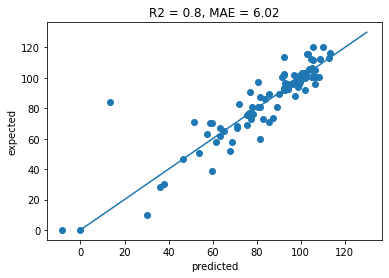

In [14]:
plt.scatter(y_pred_test,y_test)
plt.plot(np.linspace(0,130,10),np.linspace(0,130,10))
plt.title('R2 = {}, MAE = {}'.format(round(r2_score(y_pred_test,y_test),2),round(mean_absolute_error(y_pred_test,y_test),2)))
plt.xlabel('predicted')
plt.ylabel('expected')

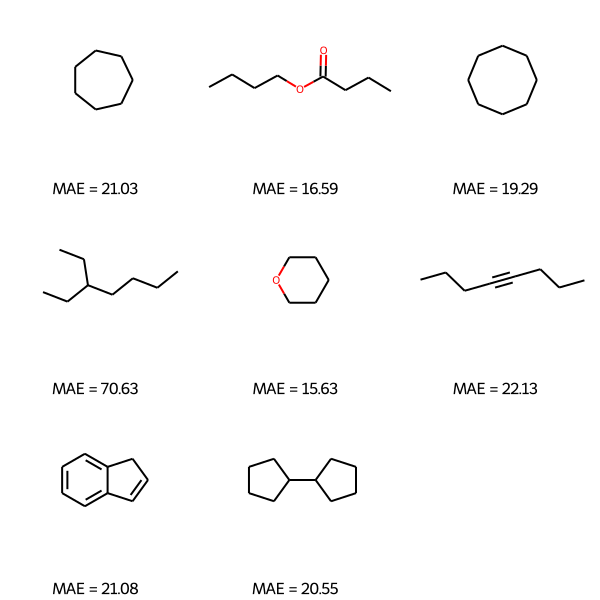

In [15]:
## Display compounds with the worst predictions
abs_error_threshold = 15

data_error = pd.DataFrame(columns=['SMILES','MAE'])
data_error['SMILES'] = X_test.iloc[np.where(mae>abs_error_threshold)[0]]['SMILES'].values
data_error['MAE'] = mae[np.where(mae>abs_error_threshold)[0]]
worst_mols = [Chem.MolFromSmiles(x) for x in data_error['SMILES'].astype('str').values]
Chem.Draw.MolsToGridImage(worst_mols,legends=['MAE'+' '+'='+' '+ str(round(x,2)) for x in list(data_error['MAE'].values)])

### Applicability domain

1. OneClassSVM

In [19]:
P      = Partition(X_train,sc.transform(X_test),mae,'OneClassSVM',np.linspace(0.001,0.96,20),gamma=0.1,kernel="rbf")
errors = P.calculate()

In [17]:
def means(x):
    vals = []
    for key, value in x.items():
        vals.append(value['error'].mean())
    return vals

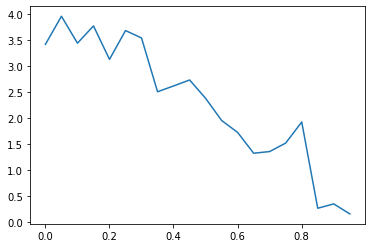

In [60]:
plt.plot(np.linspace(0.001,0.95,20),means(errors))

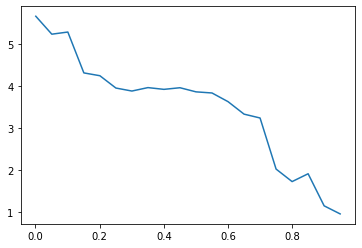

In [20]:
plt.plot(np.linspace(0.001,0.95,20),means(errors))

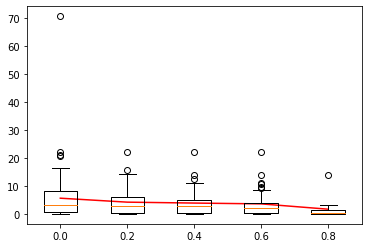

In [21]:
nu_s = [str(round(x,2)) for x in np.linspace(0.001,0.95,20)[np.arange(0,20,4)]]
means_ = np.array([x['error'] for _,x in errors.items()])[np.arange(0,20,4)]

plt.plot(np.arange(len(means_)) + 1, [np.mean(x) for x in means_], color='r')
plt.boxplot(means_,labels=nu_s)
plt.show()

2.Tanimato distance

In [22]:
P      = Partition(X_train,sc.transform(X_test),mae,'Tanimoto',np.linspace(0.1,0.96,20))
errors = P.calculate()

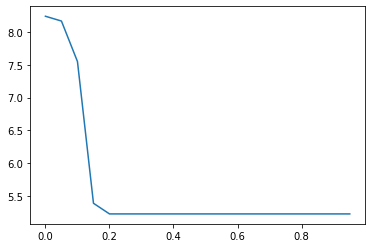

In [69]:
plt.plot(np.linspace(0.001,0.95,20),means(errors))

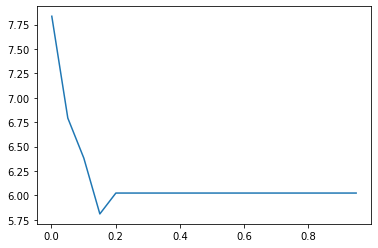

In [23]:
plt.plot(np.linspace(0.001,0.95,20),means(errors))

In [78]:
len(set(data_error['SMILES']) & set(errors[0.14526315789473684]['SMILES']))/len(data_error['SMILES'])

0.625

3. Leaverage distance

In [24]:
P      = Partition(X_train,sc.transform(X_test),mae,'leverage',np.linspace(0.1,0.96,20))
errors = P.calculate()

In [26]:
P.check_inverse()

True

In [27]:
errors

{0.1: {'error': array([], dtype=float64), 'SMILES': array([], dtype=object)},
 0.14526315789473684: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.19052631578947368: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.23578947368421052: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.28105263157894733: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.3263157894736842: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.371578947368421: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.4168421052631579: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.4621052631578947: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.5073684210526316: {'error': array([], dtype=float64),
  'SMILES': array([], dtype=object)},
 0.5526315789473684: {'error': array([], dtype=float64),
  'SMIL

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice.

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



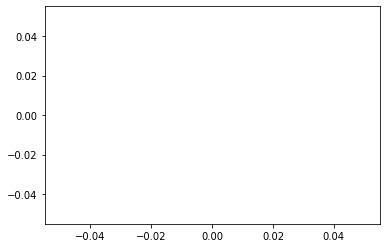

In [25]:
plt.plot(np.linspace(0.001,0.95,20),means(errors))

4. Isolation forest

In [30]:
P      = Partition(X_train,sc.transform(X_test),mae,'IsolationForest',np.linspace(0.1,0.96,20),n_estimators=200)
errors = P.calculate()

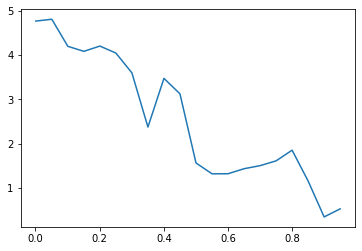

In [87]:
plt.plot(np.linspace(0.001,0.95,20),means(errors))

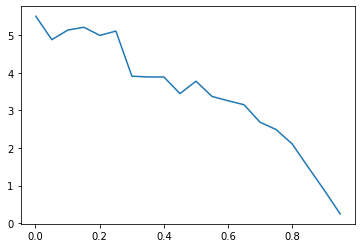

In [31]:
plt.plot(np.linspace(0.001,0.95,20),means(errors))